# Style Transfer with OpenVINO™

This notebook demonstrates style transfer with OpenVINO, using the Style Transfer Models from [ONNX Model Repository](https://github.com/onnx/models). Specifically, [Fast Neural Style Transfer](https://github.com/onnx/models/tree/master/vision/style_transfer/fast_neural_style) model, which is designed to mix the content of an image with the style of another image.

![style transfer](https://user-images.githubusercontent.com/109281183/208703143-049f712d-2777-437c-8172-597ef7d53fc3.gif)

This notebook uses five pre-trained models, for the following styles: Mosaic, Rain Princess, Candy, Udnie and Pointilism. The models are from [ONNX Model Repository](https://github.com/onnx/models) and are based on the research paper [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155) along with [Instance Normalization](https://arxiv.org/abs/1607.08022). Final part of this notebook shows live inference results from a webcam. Additionally, you can also upload a video file.

> **NOTE**: If you have a webcam on your computer, you can see live results streaming in the notebook. If you run the notebook on a server, the webcam will not work but you can run inference, using a video file.

## Preparation

### Install requirements

In [3]:
!pip install -q "openvino-dev>=2023.0.0"
!pip install -q opencv-python requests tqdm

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

('notebook_utils.py', <http.client.HTTPMessage at 0x7fc1d15bac80>)

### Imports

In [4]:
import collections
import time

import cv2
import numpy as np
from pathlib import Path
from IPython import display
from ipywidgets import interactive, ToggleButtons
from openvino.runtime import Core

import notebook_utils as utils

Select one of the styles below: Mosaic, Rain Princess, Candy, Udnie, and Pointilism to do the style transfer.

In [5]:
# Option to select different styles
styleButtons = ToggleButtons(
    options=['MOSAIC', 'RAIN-PRINCESS', 'CANDY', 'UDNIE', 'POINTILISM'],
    description="Click one of the styles you want to use for the style transfer",
    disabled=False,
    style={'description_width': '300px'})

interactive(lambda option: print(option), option=styleButtons)

interactive(children=(ToggleButtons(description='Click one of the styles you want to use for the style transfe…

## The Model

### Download the Model

The style transfer model, selected in the previous step, will be downloaded to `model_path` if you have not already downloaded it. The models are provided by the ONNX Model Zoo in `.onnx` format, which means it could be used with OpenVINO directly. However, this notebook will also show how you can use the Model Optimizer to convert ONNX to OpenVINO Intermediate Representation (IR) with `FP16` precision.

In [6]:
# Directory to download the model from ONNX model zoo
base_model_dir = "model"
base_url = "https://github.com/onnx/models/raw/main/vision/style_transfer/fast_neural_style/model"

# Selected ONNX model will be downloaded in the path
model_path = Path(f"{styleButtons.value.lower()}-9.onnx")

style_url = f"{base_url}/{model_path}"
utils.download_file(style_url, directory=base_model_dir)

'model/mosaic-9.onnx' already exists.


PosixPath('/content/model/mosaic-9.onnx')

### Convert ONNX Model to OpenVINO IR Format

In the next step, you will convert the ONNX model to OpenVINO IR format with `FP16` precision. While ONNX models are directly supported by OpenVINO runtime, it can be useful to convert them to IR format to take advantage of OpenVINO optimization tools and features. The `mo.convert_model` python function can be used for converting model, using OpenVINO Model Optimizer. The converted model is saved to the model directory. The function returns instance of OpenVINO Model class, which is ready to use in Python interface but can also be serialized to OpenVINO IR format for future execution. If the model has been already converted, you can skip this step.

In [7]:
# Construct the command for Model Optimizer.
from openvino.runtime import serialize
from openvino.tools import mo

ov_model = mo.convert_model(f"model/{styleButtons.value.lower()}-9.onnx", compress_to_fp16=True)
serialize(ov_model, f"model/{styleButtons.value.lower()}-9.xml")

In [8]:
# Converted IR model path
ir_path = Path(f"model/{styleButtons.value.lower()}-9.xml")
onnx_path = Path(f"model/{model_path}")

### Load the Model

Both the ONNX model(s) and converted IR model(s) are stored in the `model` directory.

Only a few lines of code are required to run the model. First, initialize OpenVINO Runtime. Then, read the network architecture and model weights from the `.bin` and `.xml` files to compile for the desired device. If you select `GPU` you may need to wait briefly for it to load, as the startup time is somewhat longer than `CPU`.

To let OpenVINO automatically select the best device for inference just use `AUTO`. In most cases, the best device to use is `GPU` (better performance, but slightly longer startup time).

OpenVINO Runtime can load ONNX models from [ONNX Model Repository](https://github.com/onnx/models) directly. In such cases, use ONNX path instead of IR model to load the model. It is recommended to load the OpenVINO Intermediate Representation (IR) model for the best results.

In [9]:
# Initialize OpenVINO Runtime.
ie_core = Core()

# Read the network and corresponding weights from ONNX Model.
# model = ie_core.read_model(model=onnx_path)

# Read the network and corresponding weights from IR Model.
model = ie_core.read_model(model=ir_path)

# Compile the model for CPU (or change to GPU, MYRIAD etc. for other devices)
# or let OpenVINO select the best available device with AUTO.
compiled_model = ie_core.compile_model(model=model, device_name="AUTO")

# Get the input and output nodes.
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

Input and output layers have the names of the input node and output node respectively. For *fast-neural-style-mosaic-onnx*, there is 1 input and 1 output with the `(1, 3, 224, 224)` shape.

In [10]:
print(input_layer.any_name, output_layer.any_name)
print(input_layer.shape)
print(output_layer.shape)

# Get the input size.
N, C, H, W = list(input_layer.shape)

input1 output1
[1,3,224,224]
[1,3,224,224]


### Preprocess the image
Preprocess the input image before running the model. Prepare the dimensions and channel order for the image to match the original image with the input tensor

1. Preprocess a frame to convert from `unit8` to `float32`.
2. Transpose the array to match with the network input size

In [11]:
# Preprocess the input image.
def preprocess_images(frame, H, W):
    """
    Preprocess input image to align with network size

    Parameters:
        :param frame:  input frame
        :param H:  height of the frame to style transfer model
        :param W:  width of the frame to style transfer model
        :returns: resized and transposed frame
    """
    image = np.array(frame).astype('float32')
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(src=image, dsize=(H, W), interpolation=cv2.INTER_AREA)
    image = np.transpose(image, [2, 0, 1])
    image = np.expand_dims(image, axis=0)
    return image

### Helper function to postprocess the stylized image
The converted IR model outputs a NumPy `float32` array of the [(1, 3, 224, 224)](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/fast-neural-style-mosaic-onnx/README.md) shape .

In [12]:
# Postprocess the result
def convert_result_to_image(frame, stylized_image) -> np.ndarray:
    """
    Postprocess stylized image for visualization

    Parameters:
        :param frame:  input frame
        :param stylized_image:  stylized image with specific style applied
        :returns: resized stylized image for visualization
    """
    h, w = frame.shape[:2]
    stylized_image = stylized_image.squeeze().transpose(1, 2, 0)
    stylized_image = cv2.resize(src=stylized_image, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    stylized_image = np.clip(stylized_image, 0, 255).astype(np.uint8)
    stylized_image = cv2.cvtColor(stylized_image, cv2.COLOR_BGR2RGB)
    return stylized_image

### Main Processing Function

The style transfer function can be run in different operating modes, either using a webcam or a video file.

In [13]:
def run_style_transfer(source=0, flip=True, use_popup=True, skip_first_frames=0):
    """
    Main function to run the style inference:
    1. Create a video player to play with target fps (utils.VideoPlayer).
    2. Prepare a set of frames for style transfer.
    3. Run AI inference for style transfer.
    4. Visualize the results.
    Parameters:
        source: The webcam number to feed the video stream with primary webcam set to "0", or the video path.
        flip: To be used by VideoPlayer function for flipping capture image.
        use_popup: False for showing encoded frames over this notebook, True for creating a popup window.
        skip_first_frames: Number of frames to skip at the beginning of the video.
    """
    # Create a video player to play with target fps.
    player = None
    try:
        player = utils.VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start video capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 720 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(src=frame, dsize=None, fx=scale, fy=scale,
                                   interpolation=cv2.INTER_AREA)
            # Preprocess the input image.

            image = preprocess_images(frame, H, W)

            # Measure processing time for the input image.
            start_time = time.time()
            # Perform the inference step.
            stylized_image = compiled_model([image])[output_layer]
            stop_time = time.time()

            # Postprocessing for stylized image.
            result_image = convert_result_to_image(frame, stylized_image)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()
            processing_time_det = np.mean(processing_times) * 1000

            # Visualize the results.
            f_height, f_width = frame.shape[:2]
            fps = 1000 / processing_time_det
            cv2.putText(result_image, text=f"Inference time: {processing_time_det:.1f}ms ({fps:.1f} FPS)",
                        org=(20, 40),fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=f_width / 1000,
                        color=(0, 0, 255), thickness=1, lineType=cv2.LINE_AA)

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(title, result_image)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(".jpg", result_image, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run Style Transfer Using a Webcam

Now, try to apply the style transfer model using video from your webcam. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

> **NOTE**: To use a webcam, you must run this Jupyter notebook on a computer with a webcam. If you run it on a server, you will not be able to access the webcam. However, you can still perform inference on a video file in the final step.

In [14]:
run_style_transfer(source=0, flip=True, use_popup=False)

Cannot open camera 0


### Run Style Transfer on a Video File

You can find out how the model works with a video file. For that, use any [formats supported by OpenCV](https://docs.opencv.org/4.5.1/dd/d43/tutorial_py_video_display.html). You can press the stop button to terminate anytime while the video file is running.

> **NOTE**: Sometimes, the video will be cut off when frames are corrupted. If this happens, or you experience any other problems with your video, use the [HandBrake](https://handbrake.fr/) encoder tool to create a video file in MPEG format.

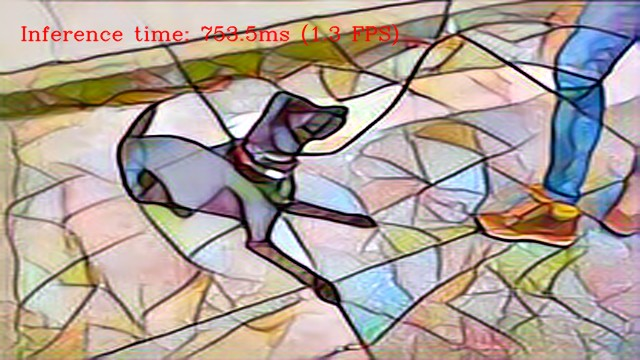

Source ended


In [15]:
video_file = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4"
run_style_transfer(source=video_file, flip=False, use_popup=False)

## References

1. [ONNX Model Zoo](https://github.com/onnx/models)
2. [Fast Neural Style Transfer](https://github.com/onnx/models/tree/main/vision/style_transfer/fast_neural_style)
3. [Fast Neural Style Mosaic Onnx - Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/fast-neural-style-mosaic-onnx/README.md)